<a href="https://colab.research.google.com/github/dileep5253/Community_Detection/blob/main/Community-Detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialisation

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
#Import data set
df = pd.read_excel('/content/gdrive/MyDrive/OnlineRetail.xlsx', header = 0) # Changed path to /content/gdrive/MyDrive/OnlineRetail.xlsx

In [6]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')


dataset dimensions are: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


In [7]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:4000]
print(df_sample)

     InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...        ...       ...                                  ...       ...   
3995    536742     22558      CLOTHES PEGS RETROSPOT PACK 24          2   
3996    536742     22379             RECYCLING BAG RETROSPOT          1   
3997    536742     22470                HEART OF WICKER LARGE         1   
3998    536742     21211       SET OF 72 SKULL PAPER  DOILIES         1   
3999    536742     22469                HEART OF WICKER SMALL         2   

             InvoiceDate  UnitPrice  CustomerID         Country  
0    2010-12-01 08:26:00       2.

## Data Pre-processing

In [8]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID)==False]

#Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')


<ipython-input-8-a50eeca40dda>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
<ipython-input-8-a50eeca40dda>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to 

In [9]:
#Count number of products and number of customers in the reduced dataset
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 137
Number of products in dataset: 1131


## Create a Bipartite Graph

In [10]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1
print(ratings)

StockCode   10002  10125  10133  10135  16014  16016  16046  16235  16237  \
CustomerID                                                                  
12431           0      0      0      0      0      0      0      0      0   
12433           0      0      0      0      0      0      0      0      0   
12583          48      0      0      0      0      0      0      0      0   
12662           0      0      0      0      0      0      0      0      0   
12748           0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18041           0      0      0      0      0      0      1      0      0   
18074           0      0      0      0      0      0      0      0      0   
18085           0      0      0      0      0      0      0      0      0   
18144           0      0      0      0      0      0      0      0      0   
18229           0      0      0      0      0      0      0      0      0   

## Convert to a Weighted Product Graph

In [11]:
import numpy as np
import pandas as pd

# Example: number of products (no_products) and binary ratings DataFrame (ratings_binary)
# no_products = 5  # Example: 5 products
# ratings_binary = pd.DataFrame([[0, 1, 0, 1, 1],   # Example: Binary ratings where 1 means purchased, 0 means not purchased
#                                [1, 1, 0, 0, 1],
#                                [0, 0, 1, 1, 0],
#                                [1, 0, 1, 1, 0],
#                                [1, 1, 1, 0, 1]])

# Initialize a zero matrix for product interactions
products_integer = np.zeros((no_products, no_products))

# Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:, [i, j]]
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2])
            products_integer[i, j] = pairings_ij
            products_integer[j, i] = pairings_ij

# Print the interaction matrix
print(products_integer)


Counting how many times each pair of products has been purchased...
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [12]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)
print(times_purchased)

Counting how many times each individual product has been purchased...
[30. 73. 27. ... 20. 63. 34.]


In [13]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
            products_weighted[j,i] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
print(products_weighted)


Building weighted product matrix...
[[0.       0.       0.       ... 0.       0.       0.015625]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.015625 0.       0.       ... 0.       0.       0.      ]]


## Visualise Weighted Product matrix

In [14]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

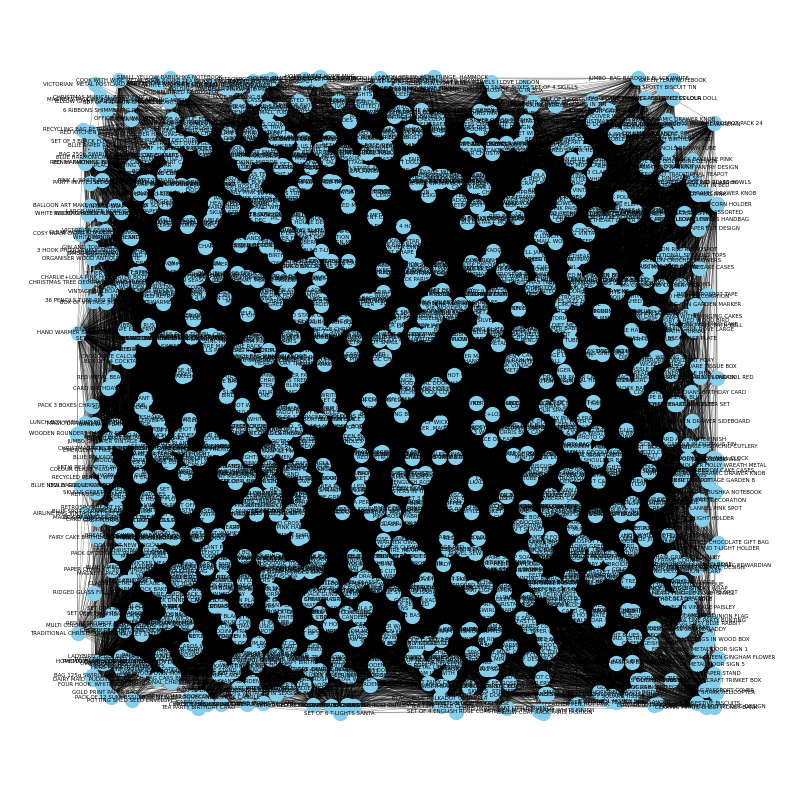

In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assuming products_weighted is a 2D NumPy array (weighted adjacency matrix)
# and nodes_labels is a list of product names or descriptions.
# Example:
# products_weighted = np.array([[...], [...], ...]) # A weighted adjacency matrix
# nodes_labels = ['product1', 'product2', 'product3', ...]

G = nx.from_numpy_array(products_weighted)  # This creates a weighted graph from the matrix

pos = nx.random_layout(G)

labels = {idx: nodes_labels[idx] for idx in range(len(nodes_labels))}

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.3, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()


#### For better visualisation, export the graph to Gephi

In [16]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

Communities detected by Louvain method:
Community 1: [0, 23, 33, 39, 43]
Community 2: [10, 25, 27, 34, 47, 48, 49]
Community 3: [3, 13, 28, 31, 40, 41]
Community 4: [4, 6, 7, 11, 15, 19, 26, 38]
Community 5: [5, 16, 22, 32, 37]
Community 6: [1, 2, 17, 18, 20, 30, 35, 44]
Community 7: [8, 12, 21, 24, 29, 42, 45]
Community 8: [9, 14, 36, 46]


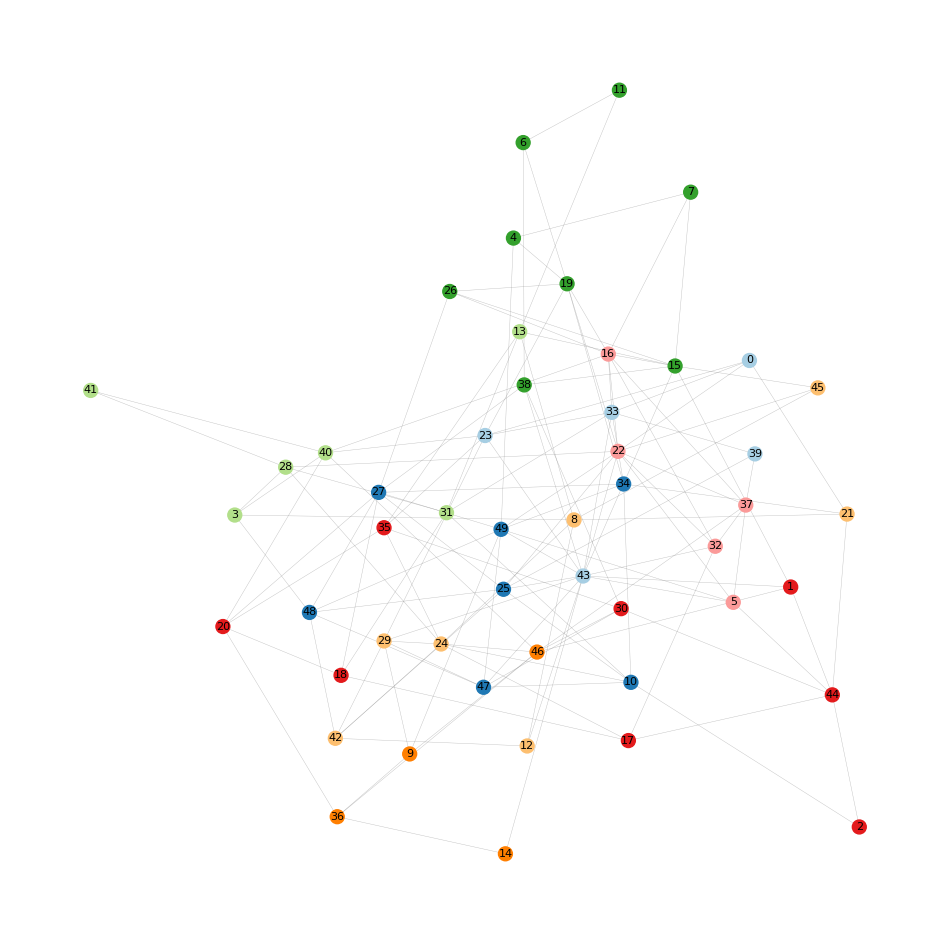

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# Function to get paired color palette for node coloring based on communities
def get_paired_color_palette(size):
    palette = []
    for i in range(size * 2):  # Generate enough colors
        palette.append(plt.cm.Paired(i))
    return palette

G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes, 10% edge probability

# Apply the Louvain method for community detection
louvain = community_louvain.best_partition(G, resolution=1.5)
values = list(louvain.values())  # List of community assignments for each node

# Initialize an empty list to store communities
communities = []

# Loop over each unique community ID to group the nodes in each community
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if louvain[n] == i]
    communities.append(nodelist)

# Print the communities
print("Communities detected by Louvain method:")
for idx, community in enumerate(communities):
    print(f"Community {idx + 1}: {community}")

palette = get_paired_color_palette(len(communities))

# Visualize the graph
plt.figure(figsize=(12, 12))
node_colors = [palette[values[node]] for node in G.nodes]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.3, alpha=0.5)
labels = {node: str(node) for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.axis('off')

# Show the plot
plt.show()


## Visualise detected communities

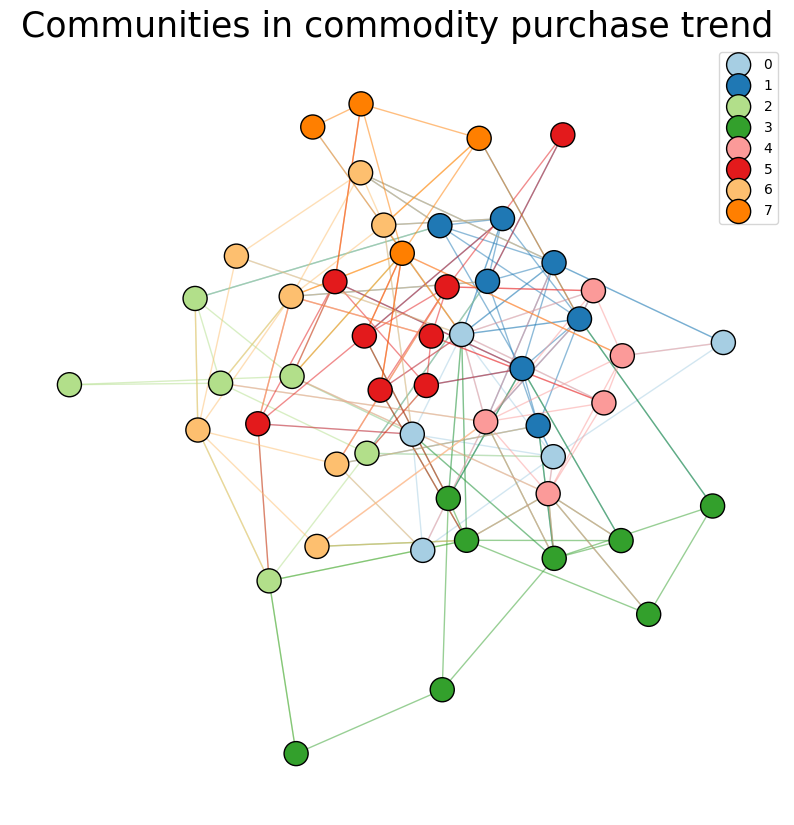

In [18]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

Modularity: 0.322705502339051


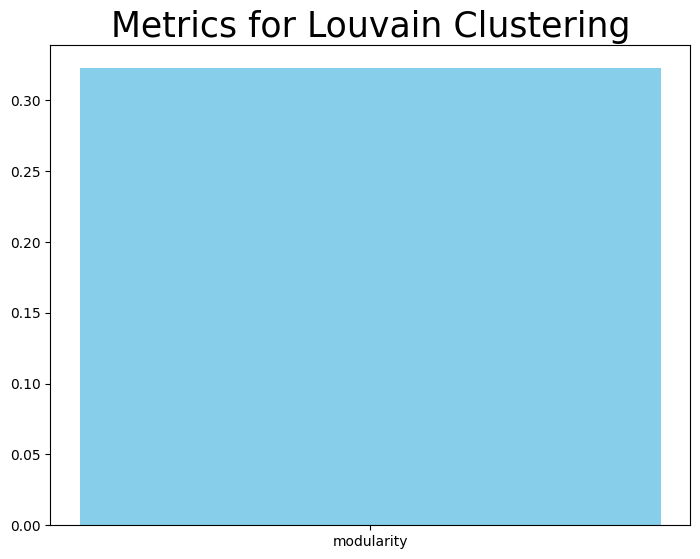

In [19]:
# Transform all the graphs in the same format
clusters = []
for cluster in range(len(set(louvain.values()))):
    cluster_set = set()
    for k, v in louvain.items():
        if v == cluster:
            cluster_set.add(k)
    clusters.append(cluster_set)  # Append the set of nodes to the clusters list

# Calculate modularity
modularity = nx.community.modularity(G, clusters)
print("Modularity:", modularity)

# Plot only modularity since 'coverage' and 'performance' are not available
x = ['modularity']
y = [modularity]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(x, y, color=['skyblue'])
plt.title('Metrics for Louvain Clustering', fontdict={'fontsize': 25})
plt.show()



## Detected Community Analysis

In [20]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 8


In [21]:
# Apply the Louvain method to the products_weighted graph (assuming it's your main graph)
louvain = community_louvain.best_partition(nx.from_numpy_array(products_weighted), resolution=1.5)
values = list(louvain.values())

# Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns=['product_description'])
products_communities['community_id'] = values  # Now 'values' should have the correct length
print(products_communities)

               product_description  community_id
0      INFLATABLE POLITICAL GLOBE              0
1          MINI FUNKY DESIGN TAPES             1
2     COLOURING PENCILS BROWN TUBE             2
3     COLOURING PENCILS BROWN TUBE             3
4      SMALL CHINESE STYLE SCISSOR             2
...                            ...           ...
1126     LETTER "S" BLING KEY RING            15
1127     LETTER "V" BLING KEY RING            15
1128                      CARRIAGE            20
1129                        Manual            21
1130                       POSTAGE             0

[1131 rows x 2 columns]


In [22]:
#Community 1
products_communities[products_communities['community_id']==1].head(40)

,product_description,community_id
1,MINI FUNKY DESIGN TAPES,1
47,BLUE ROSE FABRIC MIRROR,1
49,SET/9 CHRISTMAS T-LIGHTS SCENTED,1
102,SET/10 RED POLKADOT PARTY CANDLES,1
103,SET/10 PINK POLKADOT PARTY CANDLES,1
105,SET/10 BLUE POLKADOT PARTY CANDLES,1
160,SKULLS WRITING SET,1
161,BALLOONS WRITING SET,1
162,DINOSAURS WRITING SET,1
233,RETROSPOT SMALL TUBE MATCHES,1


## Target Advertising


In [23]:
import pandas as pd

products_weighted_pd = pd.DataFrame(products_weighted, columns=nodes_labels)

products_weighted_pd.set_index(products_weighted_pd.columns, inplace=True)  # Removed extra positional argument 'product'

products_weighted_pd.index.name = 'product'

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis=1), axis=0)

print(products_prob)


                              INFLATABLE POLITICAL GLOBE   \
product                                                     
INFLATABLE POLITICAL GLOBE                           0.00   
MINI FUNKY DESIGN TAPES                              0.00   
COLOURING PENCILS BROWN TUBE                         0.00   
COLOURING PENCILS BROWN TUBE                         0.00   
SMALL CHINESE STYLE SCISSOR                          0.00   
...                                                   ...   
LETTER "S" BLING KEY RING                            0.00   
LETTER "V" BLING KEY RING                            0.00   
CARRIAGE                                             0.00   
Manual                                               0.00   
POSTAGE                                              0.75   

                              MINI FUNKY DESIGN TAPES  \
product                                                 
INFLATABLE POLITICAL GLOBE                        0.0   
MINI FUNKY DESIGN TAPES            

In [24]:
#Saving the trained model for use in the UI
products_prob.to_csv('products_prob.csv')

---
## Testing



In [25]:
#Add item to basket
basket = ['HOME BUILDING BLOCK WORD']
#Select the number of relevant items to suggest
no_of_suggestions = 3

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['ASSORTED COLOUR BIRD ORNAMENT', 'LOVE BUILDING BLOCK WORD', 'BATH BUILDING BLOCK WORD']


In [26]:
pip install networkx matplotlib


In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph (e.g., Erdos-Renyi graph)
G = nx.erdos_renyi_graph(50, 0.1)  # 50 nodes, 10% probability of an edge between nodes


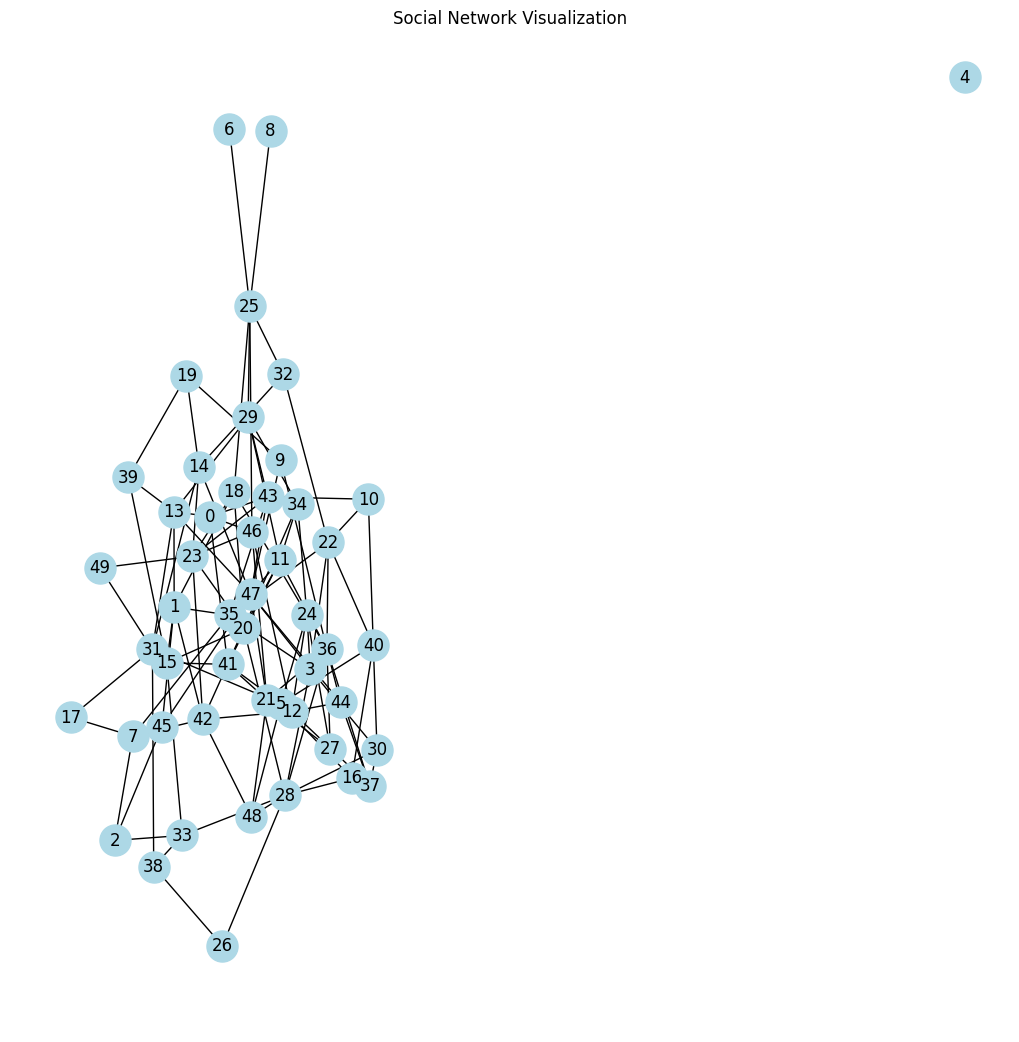

In [28]:
# Draw the network
plt.figure(figsize=(10, 10))  # Set the size of the plot
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=12)
plt.title("Social Network Visualization")
plt.show()


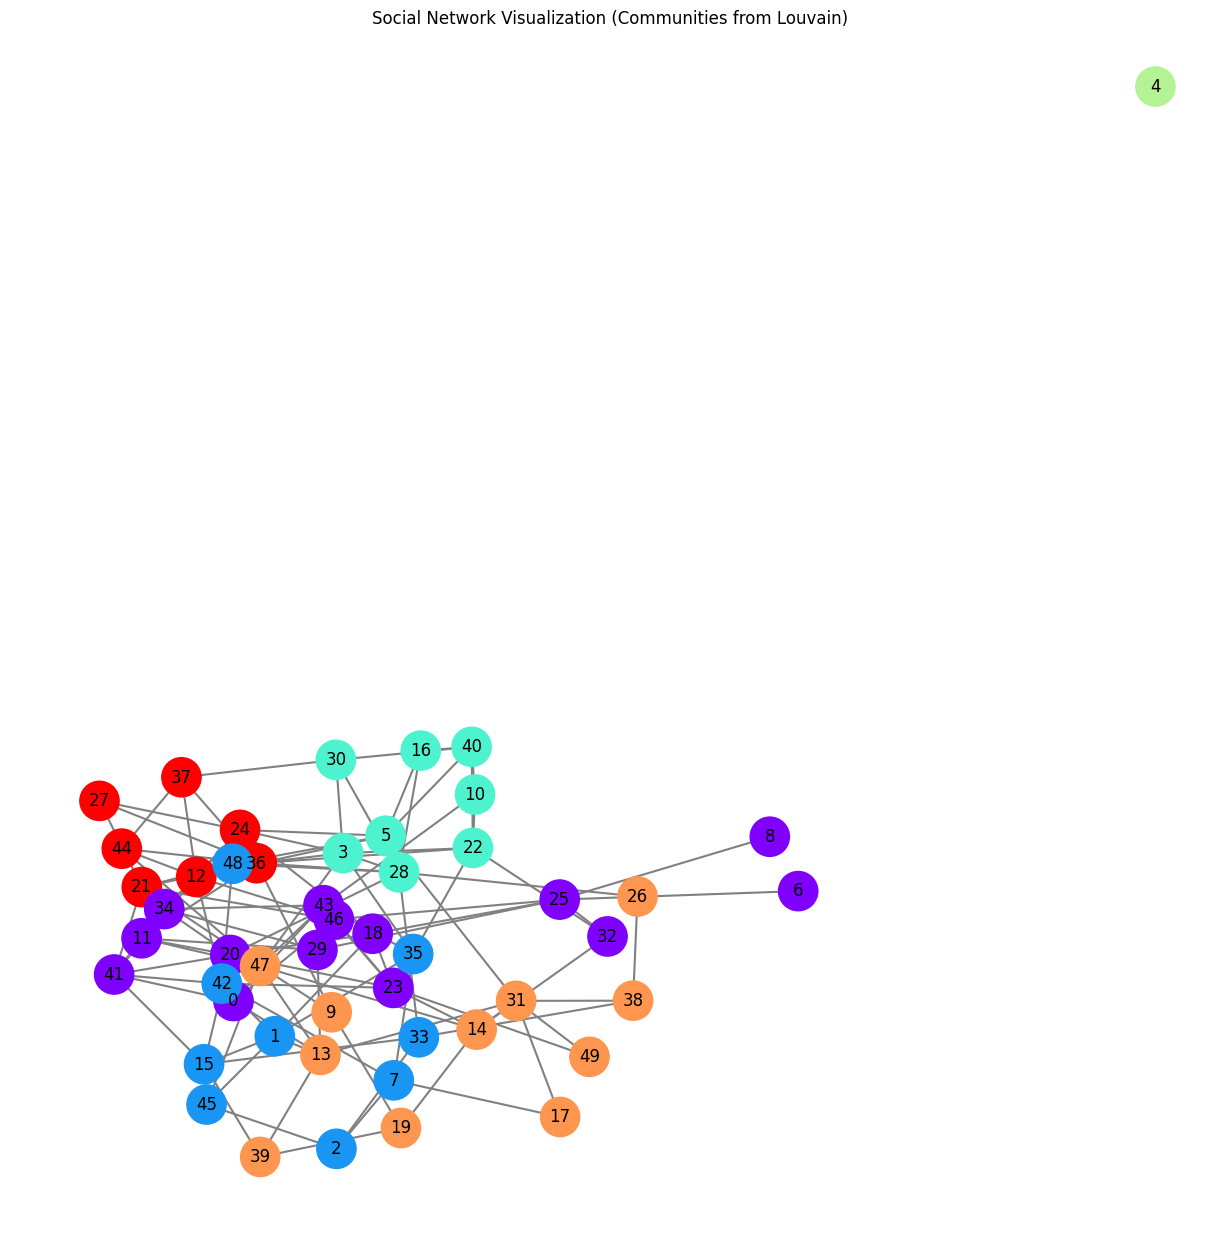

In [29]:
# Assuming you have already detected communities, like using the Louvain method
from community import community_louvain

# Detect communities (partition)
partition = community_louvain.best_partition(G)

# Color nodes based on community
community_color = [partition[node] for node in G.nodes]
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color=community_color, cmap=plt.cm.rainbow, font_size=12, font_color='black', edge_color='gray', width=1.5)
plt.title("Social Network Visualization (Communities from Louvain)")
plt.show()


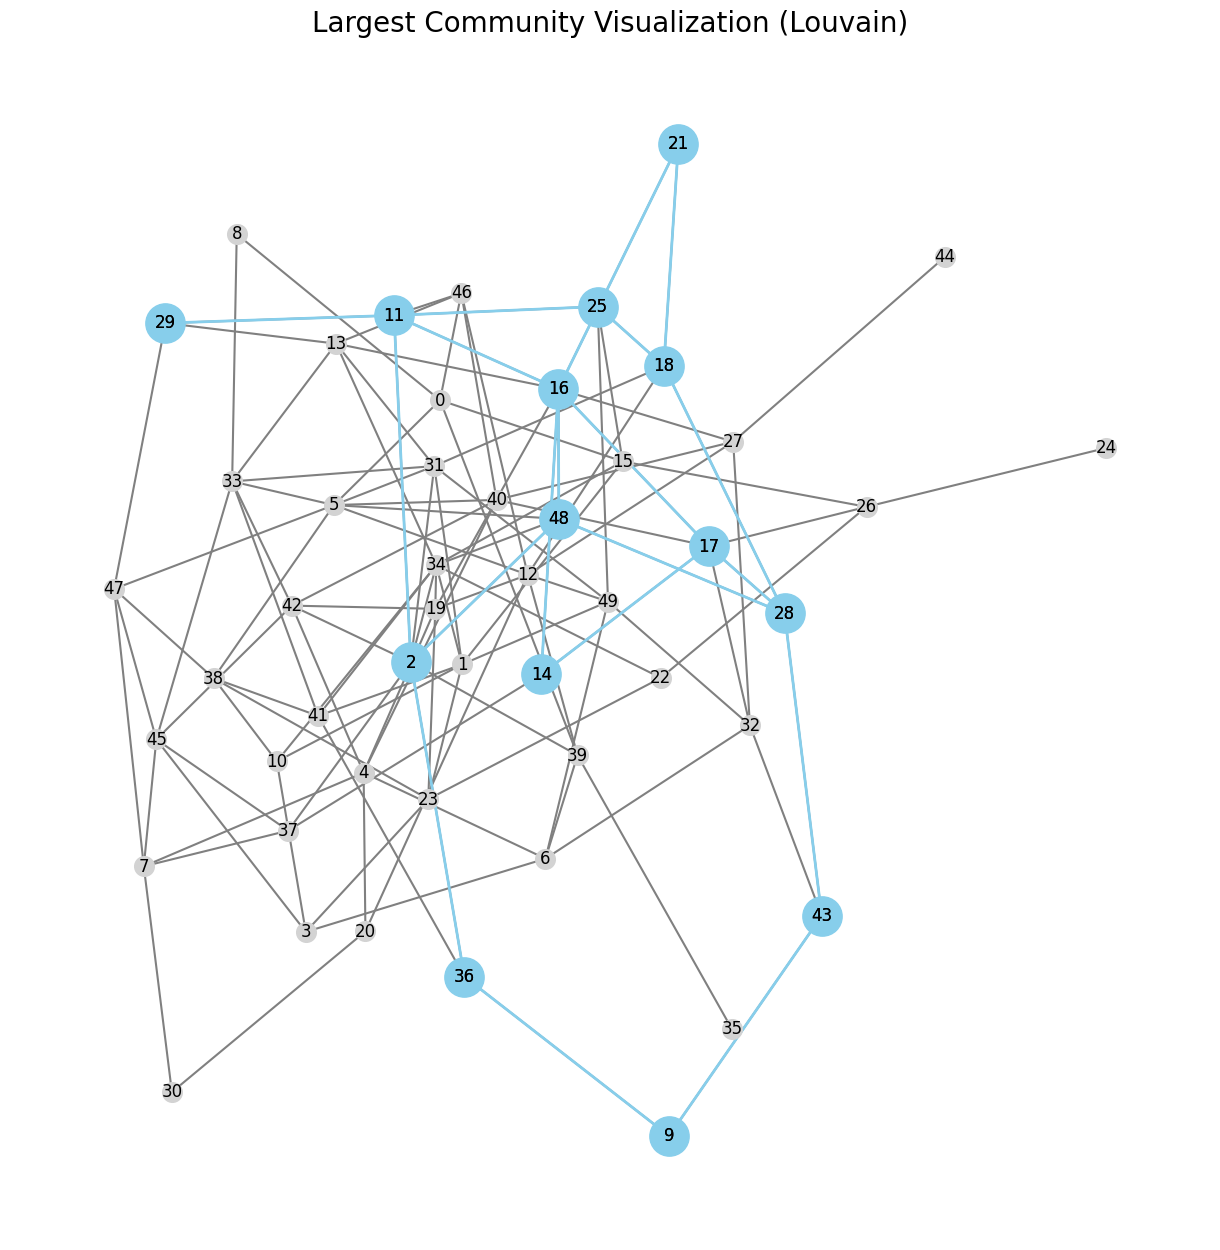

In [30]:

# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
# Import the community_louvain module directly
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Find the largest community
# Count the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Find the community with the maximum size
largest_community_id = max(community_sizes, key=community_sizes.get)

# Get the nodes belonging to the largest community
largest_community_nodes = [node for node, community_id in partition.items() if community_id == largest_community_id]

# Create a subgraph for the largest community
largest_community_subgraph = G.subgraph(largest_community_nodes)

# Choose a layout for visualization (Spring layout)
pos = nx.spring_layout(G, seed=42)  # Positions for nodes using spring layout

# Create the plot
plt.figure(figsize=(12, 12))

# Draw the entire graph with light gray nodes for background
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgray', font_size=12, font_color='black', edge_color='gray', width=1.5)

# Then, draw the largest community with a distinct color (e.g., 'skyblue')
nx.draw(largest_community_subgraph, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=12, font_color='black', edge_color='skyblue', width=2)

# Title for the plot
plt.title("Largest Community Visualization (Louvain)", fontsize=20)

# Show the plot
plt.show()


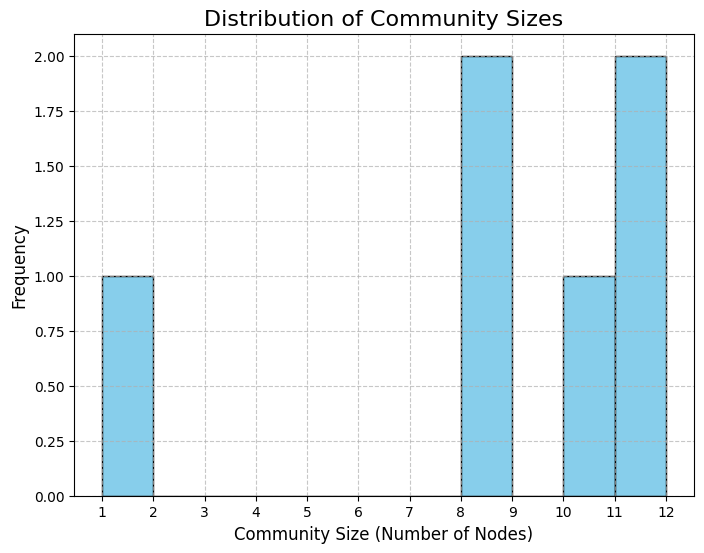

In [31]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Calculate the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Plot the distribution of community sizes
plt.figure(figsize=(8, 6))

# Plot a histogram of community sizes
plt.hist(community_sizes.values(), bins=range(1, max(community_sizes.values()) + 1), color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Community Sizes', fontsize=16)
plt.xlabel('Community Size (Number of Nodes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(1, max(community_sizes.values()) + 1))
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()
